In [15]:
!pip install cmocean
import netCDF4 as nt                      
import xarray as xr                   
import cmocean                        
import os
import numpy as np
import matplotlib.pyplot as plt

In [17]:
file = nt.Dataset("P4_chlorophyll_data.nc")


In [19]:
print("variables", file.variables.keys()) #to get all var. names
print()
chlor = file.variables['chlor_a']
print("chlor\b", chlor)
print("chlor \b", chlor.shape)
print("chlor \b", chlor[:])
print()
print('dimensions', file.dimensions)

variables dict_keys(['time', 'lon', 'lat', 'crs', 'chlor_a'])

chlo <class 'netCDF4.Variable'>
float32 chlor_a(time, lat, lon)
    standard_name: mass_concentration_of_chlorophyll_a_in_sea_water
    long_name: Chlorophyll-a concentration in seawater (not log-transformed), generated by as a blended combination of OCI, OCI2, OC2 and OCx algorithms, depending on water class memberships
    units: milligram m-3
    grid_mapping: crs
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
    ancillary_variables: chlor_a_log10_rmsd chlor_a_log10_bias
    parameter_vocab_uri: http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    units_nonstandard: mg m^-3
unlimited dimensions: time
current shape = (12, 4320, 8640)
filling off
chlor (12, 4320, 8640)
chlor [[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -

In [20]:
xrfile = xr.open_dataset('P4_chlorophyll_data.nc')

In [23]:
print("datasets[0].data_vars", xrfile.data_vars)

datasets[0].data_vars Data variables:
    crs      int32 ...
    chlor_a  (time, lat, lon) float32 ...


### This global map was just to see what the data showed, and whether it looked mostly accurate/believable concerning chlorophyll-a data, and I could get an idea of how complete the data is too. 

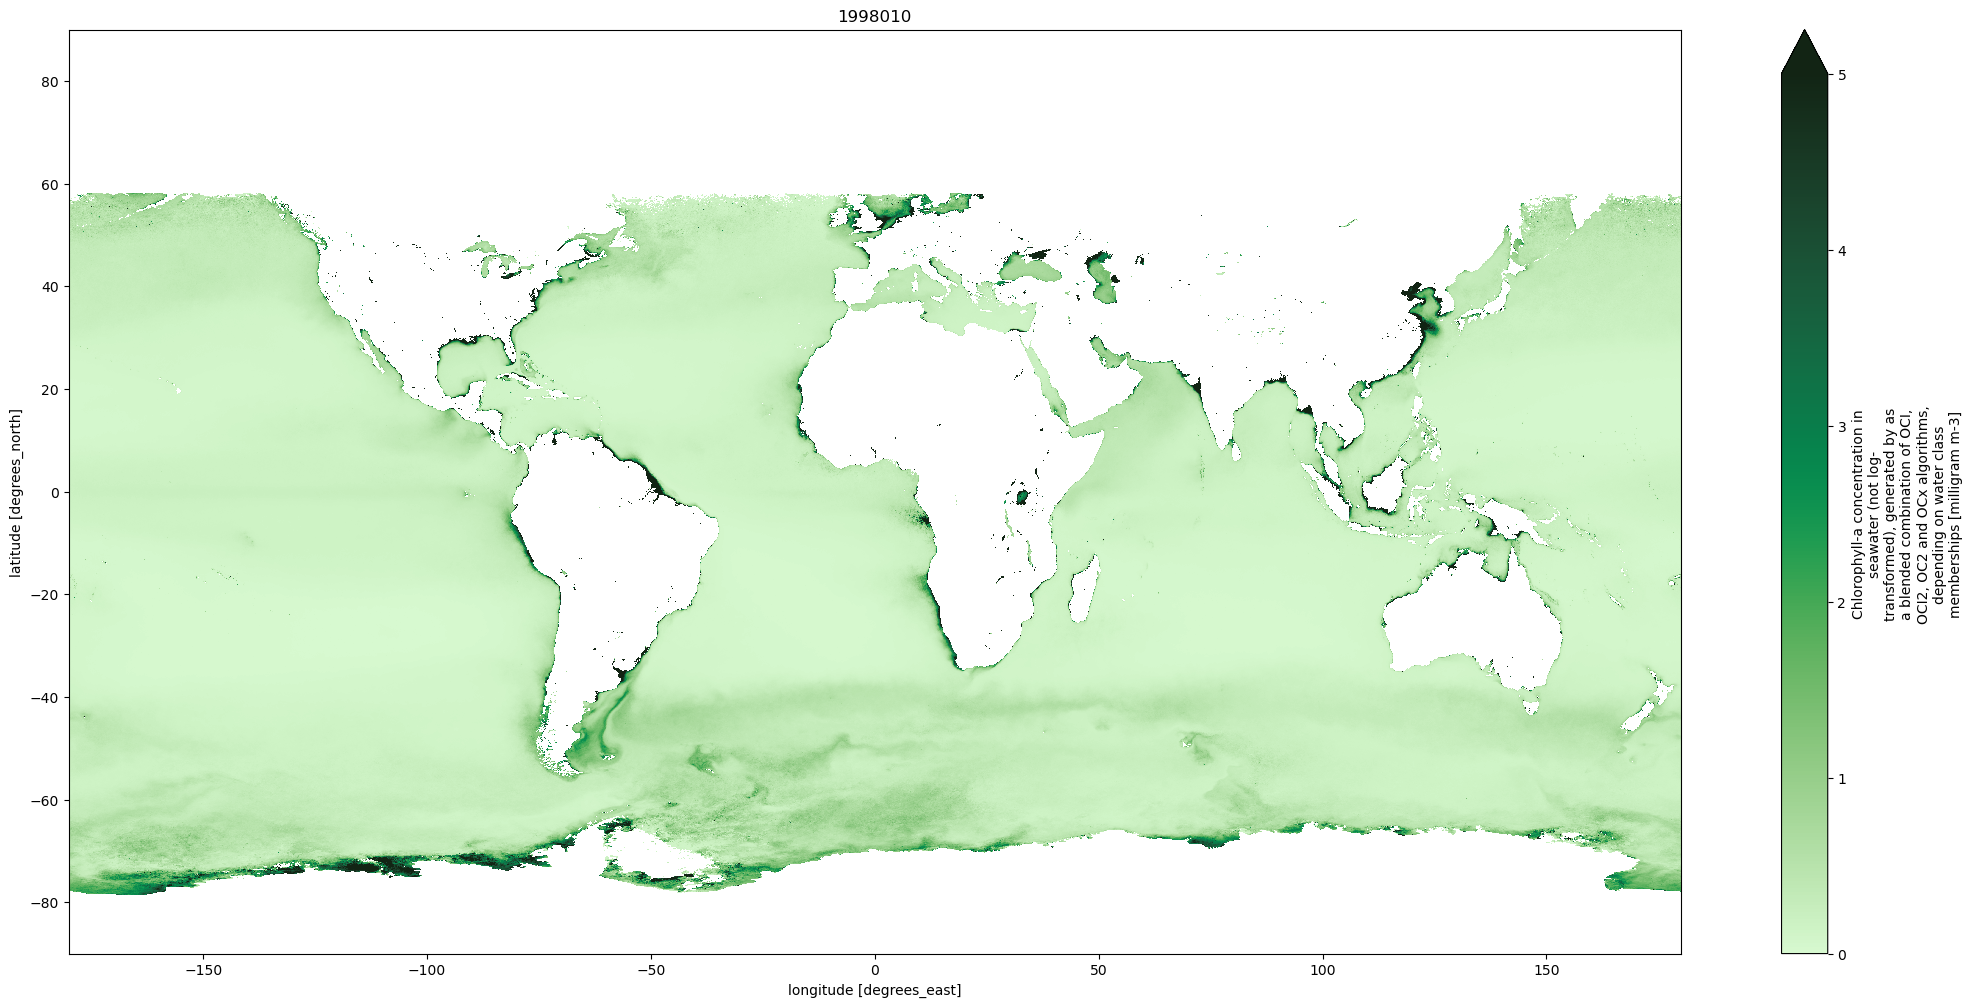

In [36]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean

# loading data NETCDF
xrfile = xr.open_dataset('P4_chlorophyll_data.nc')

# extracting chlor  data
chlorophyll = xrfile['chlor_a']

# global map
chlorophyll.isel(time=0).plot(x='lon', y='lat', figsize=(26,12), vmin=0, vmax=5, cmap=cmocean.cm.algae)

# title
plt.title(xrfile.attrs['time_coverage_start'][:7])

plt.show()

### Figure 1 code, bathymetry chart in Vancouver Island region. 

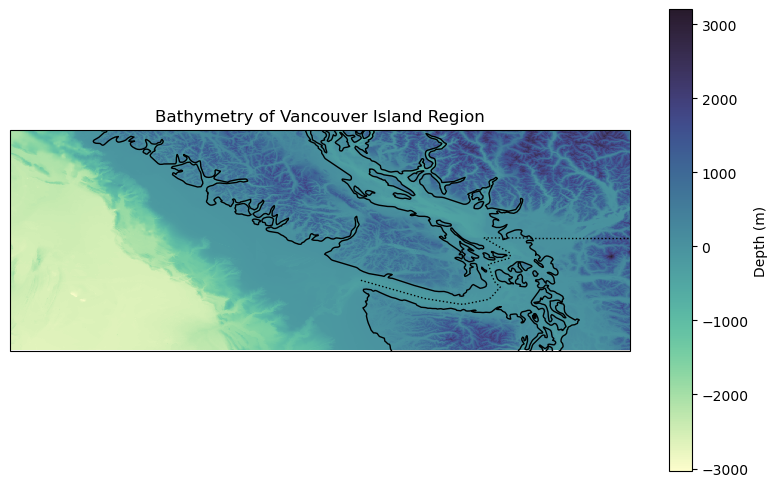

In [31]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

#data downloaded from GMRT, vancoucer island revion 
bathymetry = xr.open_dataset("P4_Cascadia_GMRT.grd")

# variables + bathy
lon = bathymetry["lon"]
lat = bathymetry["lat"]
depth = bathymetry["altitude"]  

# creating plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# plotting 
plt.pcolormesh(lon, lat, depth, cmap=cmocean.cm.deep, shading="auto")

# features
ax.coastlines()
ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.BORDERS, linestyle=":")
plt.colorbar(label="Depth (m)")

# labels, title,
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bathymetry of Vancouver Island Region")

plt.show()


### Code for figure 2. I had to redo this graph quite a few times, as none of the dimensions were working and the chart kept appearing extremely pixelated. So I ended up using the GSHHG data so that the map would be higher resolution and the borders between coast and land would be clear. 


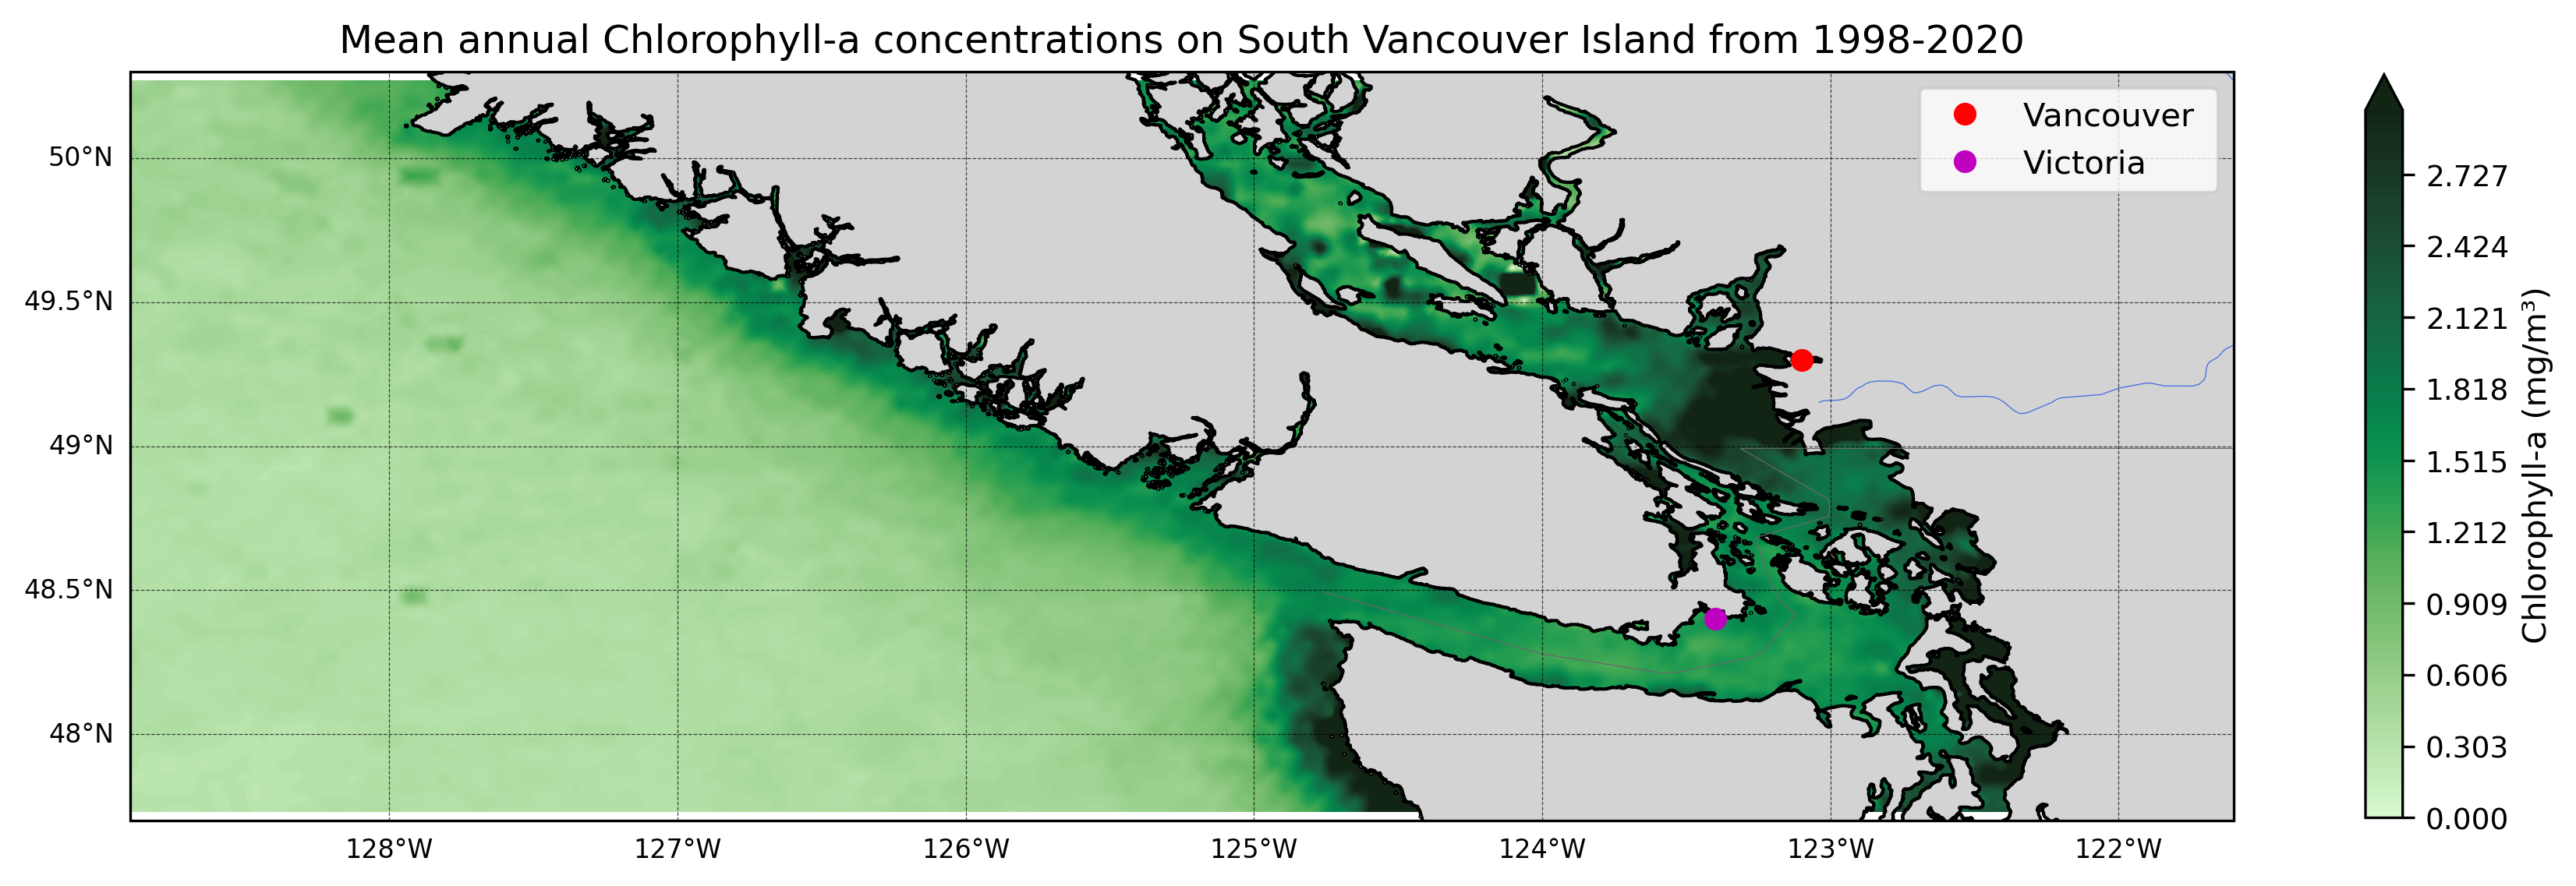

In [102]:
import matplotlib.pyplot as plt
import cmocean
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap

# opeining netcdf  file
xrfile = xr.open_dataset("P4_chlorophyll_data.nc")  # Change to your actual file path

# Region
lat_max, lat_min = 50.3, 47.7
lon_min, lon_max = -128.9, -121.6

# Select the first time step if 'time' exists
if 'time' in xrfile.dims:
    ds_slice = xrfile.isel(time=0).sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_slice = xrfile.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

# chlorophyll data
chlor_a_slice = ds_slice['chlor_a'].squeeze()

# original grid- getting original 
lons = chlor_a_slice.lon.values
lats = chlor_a_slice.lat.values
chlor_data = chlor_a_slice.values

# Create mesh grid from original coordinates
lon_mesh, lat_mesh = np.meshgrid(lons, lats)

# Create higher resolution grid (increase these numbers for even higher resolution)
hi_res_lons = np.linspace(lon_min, lon_max, 1000)
hi_res_lats = np.linspace(lat_min, lat_max, 1000)
hi_res_lon_mesh, hi_res_lat_mesh = np.meshgrid(hi_res_lons, hi_res_lats)

# Prepare original data for interpolation (flatten the arrays)
points = np.column_stack((lon_mesh.flatten(), lat_mesh.flatten()))
values = chlor_data.flatten()

# Remove NaN values for interpolation
valid_mask = ~np.isnan(values)
valid_points = points[valid_mask]
valid_values = values[valid_mask]

# Interpolate data to higher resolution grid
hi_res_chlor = griddata(valid_points, valid_values, 
                        (hi_res_lon_mesh, hi_res_lat_mesh), 
                        method='cubic')

# Calculate figure size dynamically (preserve aspect ratio)
lat_range = lat_max - lat_min
lon_range = lon_max - lon_min
fig_width = 12  # Standard width
fig_height = (lat_range / lon_range) * fig_width  # Adjust height to prevent stretching

# Create figure with Cartopy projection
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(fig_width, fig_height), 
                      subplot_kw={'projection': projection}, 
                      dpi=300)

# Set map extent
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

# Create contours with high-resolution interpolated data
# Use many levels for smooth appearance
levels = np.linspace(0, 3, 100)  # 100 levels for very smooth transitions
im = ax.contourf(hi_res_lons, hi_res_lats, hi_res_chlor, 
                levels=levels, cmap=cmocean.cm.algae, 
                transform=projection, extend='max')

# Add GSHHG high-resolution coastline data
# This uses the highest available resolution from GSHHG via Cartopy
land_feature = cfeature.GSHHSFeature(scale='full', levels=[1], facecolor='lightgray', edgecolor='black')
ax.add_feature(land_feature)

# Add other high-resolution features
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.3, edgecolor='dimgray')
ax.add_feature(cfeature.LAKES.with_scale('10m'), alpha=0.7, facecolor='aliceblue', edgecolor='navy')
ax.add_feature(cfeature.RIVERS.with_scale('10m'), linewidth=0.3, edgecolor='royalblue')
ax.plot([-123.1],[49.3], 'ro', label="Vancouver ")
ax.plot([-123.4],[48.4], 'mo', label="Victoria ")

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.3, 
                 color='black', alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Chlorophyll-a (mg/m³)', shrink=0.8)
cbar.ax.tick_params(labelsize=9)

# Add title
ax.set_title(f'Mean annual Chlorophyll-a concentrations on South Vancouver Island from 1998-2020')

# Adjust layout
plt.tight_layout()
plt.legend()

# Save figure with high resolution
plt.savefig("chlorophyll_gshhg_map.png", dpi=600, bbox_inches='tight')

# Show the final plot
plt.show()

### Code for figure 3. I also had to redo this one quite a few times as the white spaces were far too wide, and in instances where the maps were close together the chlorophyll levels were not appearing. 

/var/folders/9y/ygs7_xrd1ms7qwvkvfm1l58r0000gn/T/ipykernel_56432/2114740401.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)  # Force tight layout with no extra padding


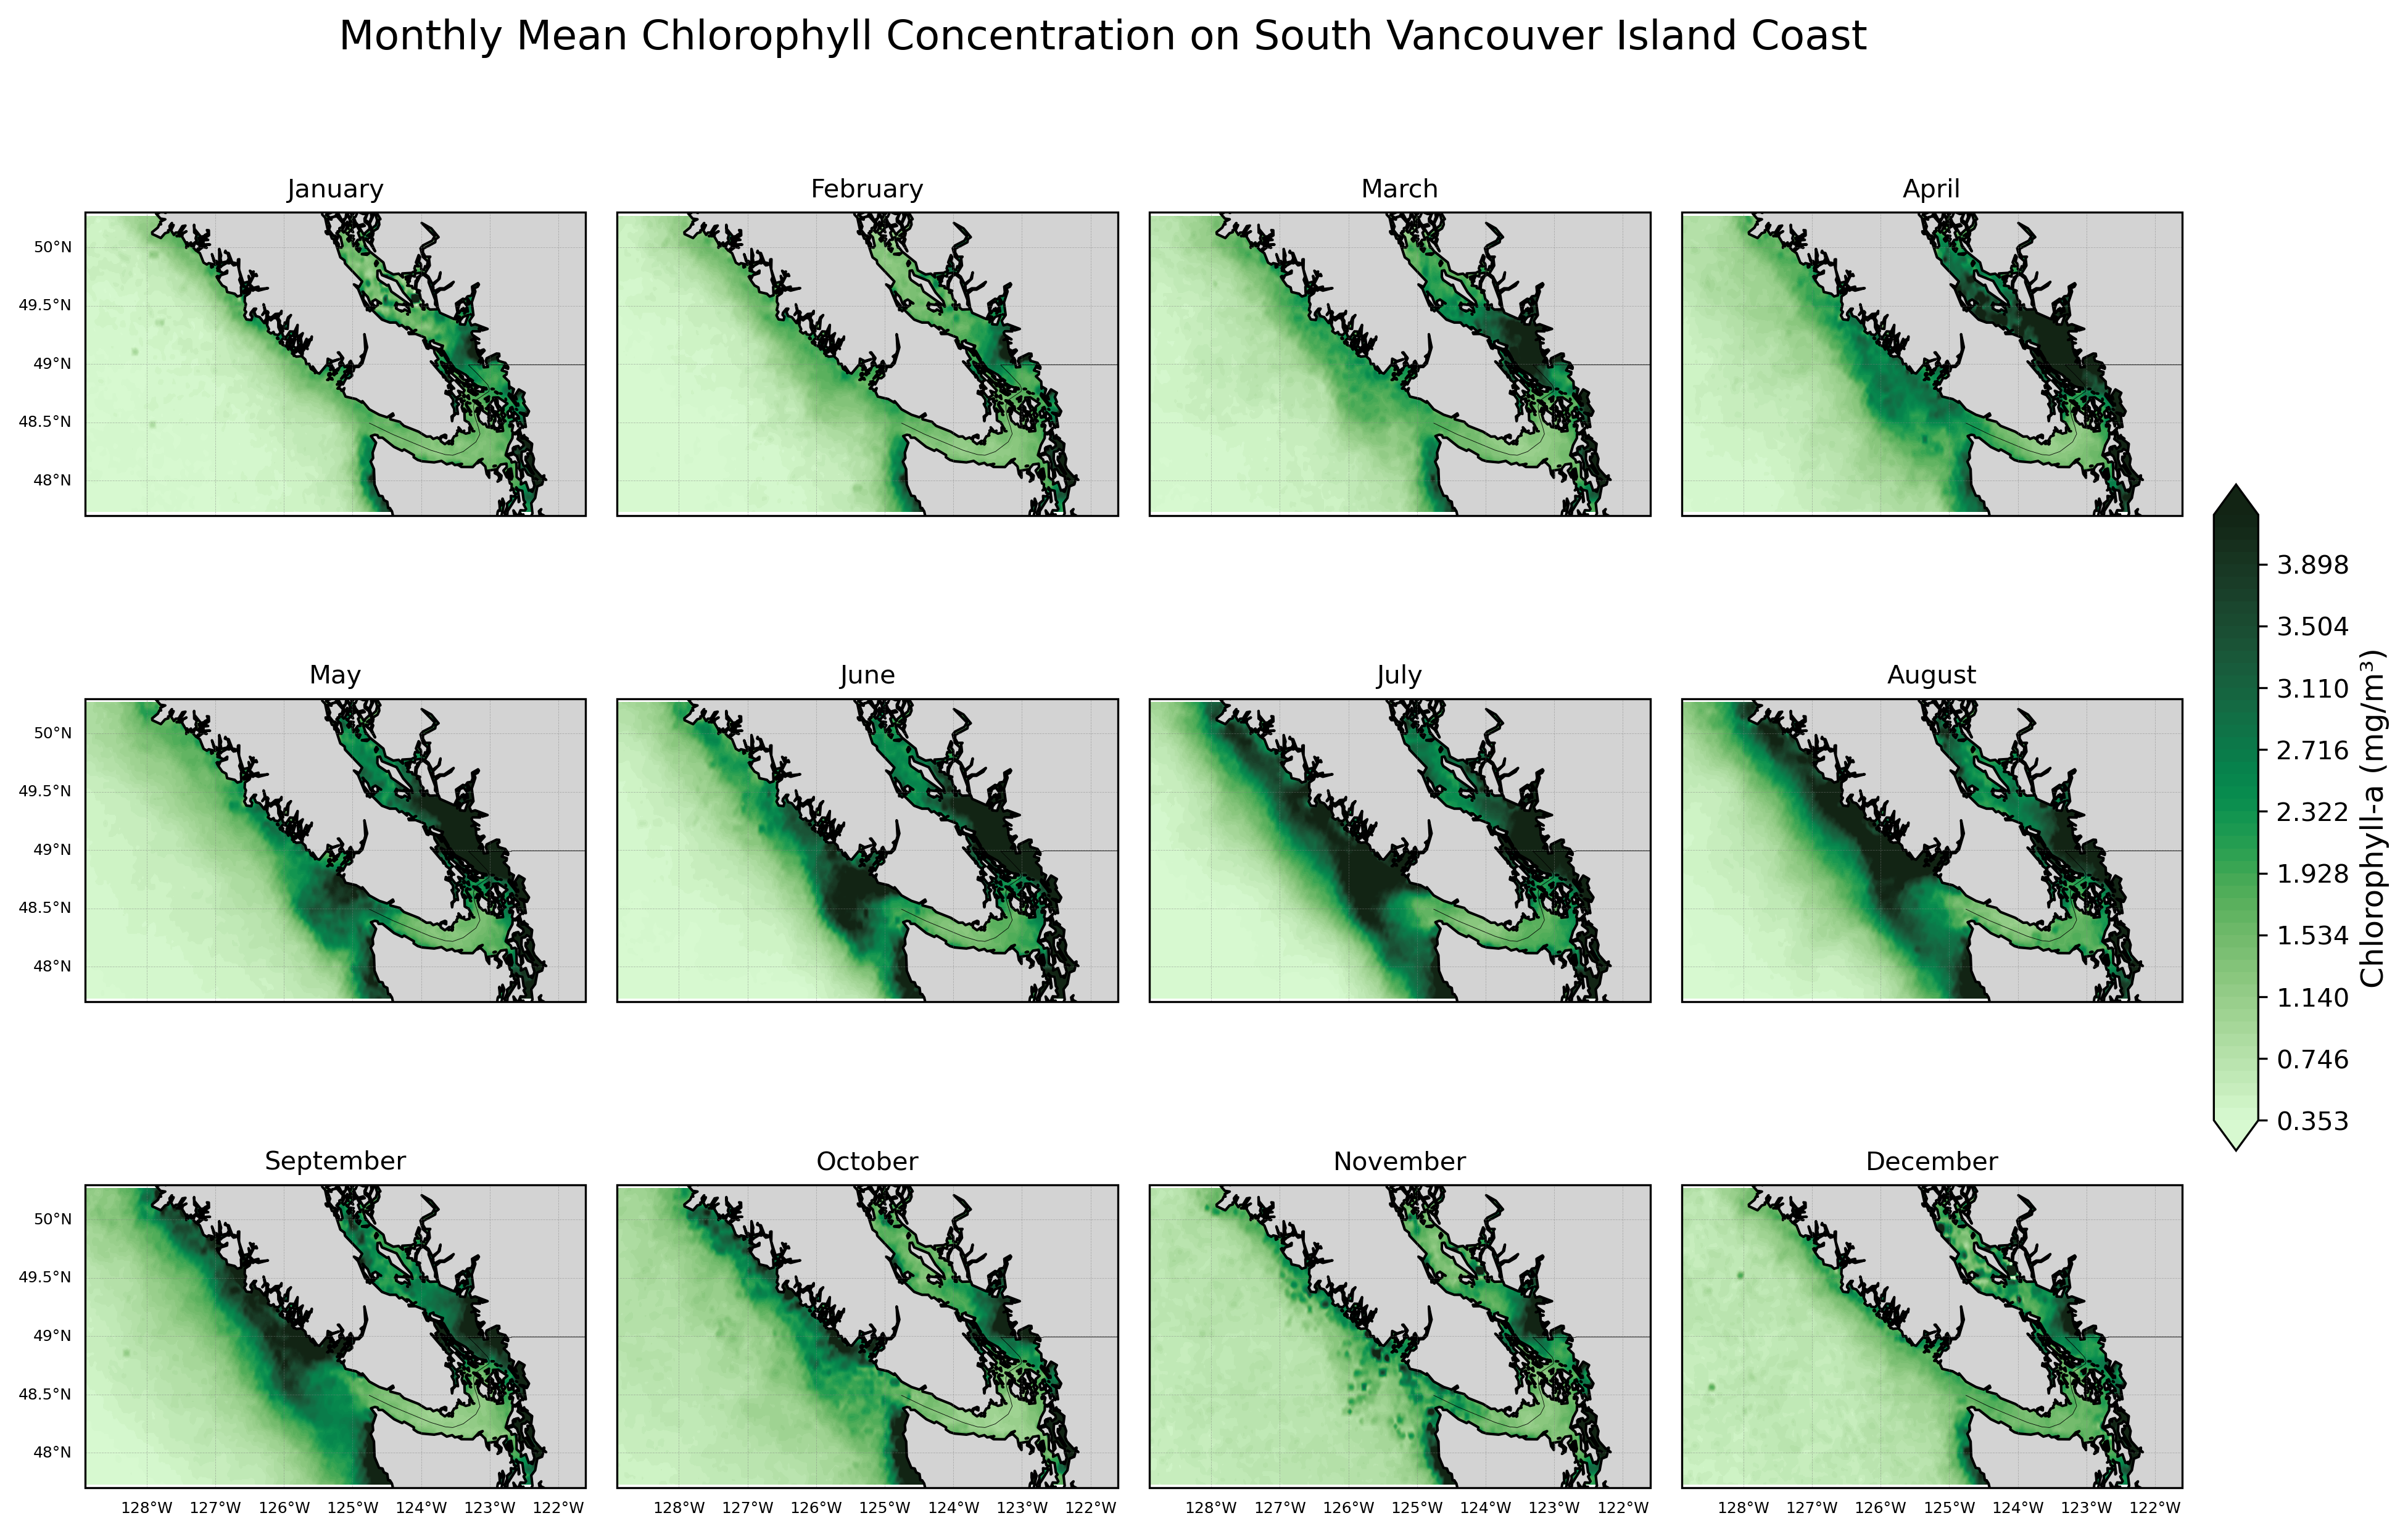

In [187]:
import matplotlib.pyplot as plt
import cmocean
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap

# Open NetCDF file
xrfile = xr.open_dataset("P4_chlorophyll_data.nc")

# Define region
lat_max, lat_min = 50.3, 47.7
lon_min, lon_max = -128.9, -121.6

# Select the region
region_data = xrfile.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

# Get 12 months of data
# Assuming time dimension exists and has monthly data
if 'time' not in region_data.dims:
    raise ValueError("Time dimension not found in dataset")

# Get the chlorophyll variable
chlor_var = region_data['chlor_a']

# Get month names for titles
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Create figure with 4x3 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 9), dpi=300, 
                         subplot_kw={'projection': projection})


# Find overall min and max values for consistent colorbar scaling
# You might want to adjust this range to highlight seasonal variations
vmin = np.nanpercentile(chlor_var.values, 5)  # 5th percentile to avoid outliers
vmax = np.nanpercentile(chlor_var.values, 95)  # 95th percentile to avoid outliers

# Create 12 subplots - one for each month
for i in range(12):
    # Select the data for this month
    # If data is already by month, select by index
    # If data has actual timestamps, you might need to adjust this filtering
    if chlor_var.time.size >= 12:
        monthly_data = chlor_var.isel(time=i).squeeze()
    else:
        print(f"Warning: Less than 12 time points ({chlor_var.time.size}). Using available data.")
        monthly_data = chlor_var.isel(time=min(i, chlor_var.time.size-1)).squeeze()
    
    # Get coordinates
    lons = monthly_data.lon.values
    lats = monthly_data.lat.values
    chlor_data = monthly_data.values
    
    # Create mesh grid from original coordinates
    lon_mesh, lat_mesh = np.meshgrid(lons, lats)
    
    # Create higher resolution grid
    hi_res_lons = np.linspace(lon_min, lon_max, 500)  # Reduced from 1000 for faster processing
    hi_res_lats = np.linspace(lat_min, lat_max, 500)  # Reduced from 1000 for faster processing
    hi_res_lon_mesh, hi_res_lat_mesh = np.meshgrid(hi_res_lons, hi_res_lats)
    
    # Prepare original data for interpolation
    points = np.column_stack((lon_mesh.flatten(), lat_mesh.flatten()))
    values = chlor_data.flatten()
    
    # Remove NaN values for interpolation
    valid_mask = ~np.isnan(values)
    valid_points = points[valid_mask]
    valid_values = values[valid_mask]
    
    # Skip interpolation if no valid data
    if len(valid_values) == 0:
        continue
        
    # Interpolate data to higher resolution grid
    hi_res_chlor = griddata(valid_points, valid_values, 
                           (hi_res_lon_mesh, hi_res_lat_mesh), 
                           method='cubic')
    
    # Create subplot
    ax = axes[i // 4, i % 4]  # Access subplot using 2D indexing
    ax.set_aspect(1.7)  # Adjust this value as needed
    
    # Set map extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)
    
    # Create contours with high-resolution interpolated data
    levels = np.linspace(vmin, vmax, 50)  # 50 levels for smooth transitions
    im = ax.contourf(hi_res_lons, hi_res_lats, hi_res_chlor, 
                    levels=levels, cmap=cmocean.cm.algae, 
                    transform=projection, extend='both',
                    vmin=vmin, vmax=vmax)
    
    # Add GSHHG high-resolution coastline data
    land_feature = cfeature.GSHHSFeature(scale='intermediate', levels=[1], 
                                       facecolor='lightgray', edgecolor='black')
    ax.add_feature(land_feature)
    
    # Add simplified features for subplots (for clarity and speed)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.2)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.7, 
                  facecolor='aliceblue', edgecolor='navy', linewidth=0.2)
    
    # Add simplified gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.2, 
                     color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    
    # Only show certain labels for cleaner layout
    if i < 8:  # No bottom labels for top two rows
        gl.bottom_labels = False
    if i % 4 != 0:  # No left labels except for leftmost column
        gl.left_labels = False
        
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    
    # Add month title
    ax.set_title(month_names[i], fontsize=10)

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([1.0, 0.3, 0.02, 0.4])  # Move colorbar further right
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.set_label('Chlorophyll-a (mg/m³)', fontsize=12)

# Add overall title
plt.suptitle('Monthly Mean Chlorophyll Concentration on South Vancouver Island Coast', 
            fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout(pad=1)  # Force tight layout with no extra padding

# Save figure with high resolution
plt.savefig("monthly_chlorophyll_maps.png", dpi=600, bbox_inches='tight')

# Show the final plot
plt.show()

### Code for figure 4 at a chosen coordinate and the mean 

NetCDF file variables:
- time: (12,)
- lon: (8640,)
- lat: (4320,)
- crs: ()
- chlor_a: (12, 4320, 8640)


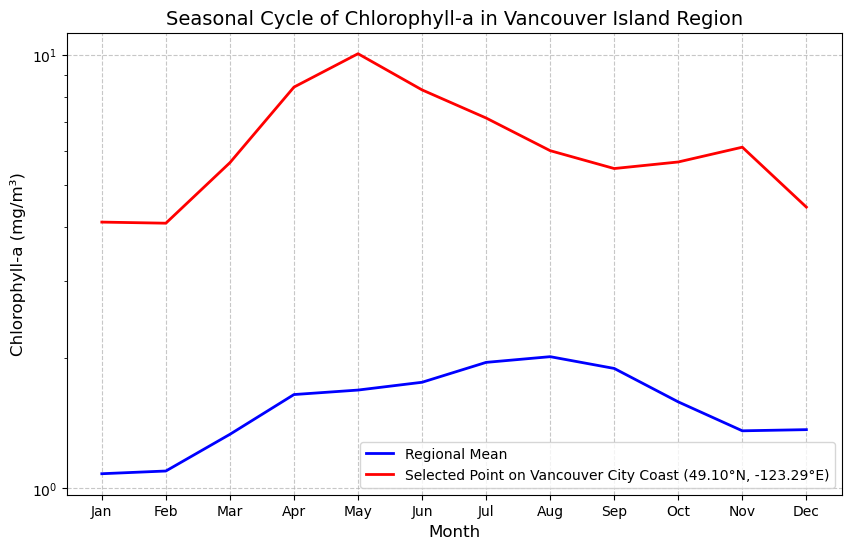

   Month  Regional Mean  Selected Point
0    Jan       1.079415        4.111359
1    Feb       1.095105        4.087532
2    Mar       1.330946        5.638729
3    Apr       1.644144        8.425567
4    May       1.683768       10.060908
5    Jun       1.755031        8.300823
6    Jul       1.950723        7.148956
7    Aug       2.010752        6.009886
8    Sep       1.888847        5.465339
9    Oct       1.581240        5.659556
10   Nov       1.355943        6.122078
11   Dec       1.364362        4.452377


In [209]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd

# Load the chlorophyll data using netCDF4
nc_file = nc.Dataset('P4_chlorophyll_data.nc', 'r')

# Print basic information about the file structure
print("NetCDF file variables:")
for var in nc_file.variables:
    print(f"- {var}: {nc_file.variables[var].shape}")

# Extract the chlorophyll data (adjust variable name as needed)
chla = nc_file.variables['chlor_a'][:]  # Replace 'chlor_a' with actual variable name

# Extract lat and lon
lat = nc_file.variables['lat'][:]  # Replace with actual latitude variable name
lon = nc_file.variables['lon'][:]  # Replace with actual longitude variable name

# Define Vancouver Island region
lat_max, lat_min = 50.3, 47.7
lon_min, lon_max = -128.9, -121.6

# Find indices for the region
lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]
lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]

# Extract region data
region_data = chla[:, lat_indices[0]:lat_indices[-1]+1, lon_indices[0]:lon_indices[-1]+1]

# Calculate regional mean for each time step
regional_means = np.nanmean(region_data, axis=(1, 2))

# Reshape to monthly data (assuming 12 months per year)
num_years = len(regional_means) // 12
monthly_means = regional_means.reshape(num_years, 12).mean(axis=0)
months = np.arange(1, 13)

# Find chlorophyll data at selected coordinate (49.104348, -123.291766)
selected_lat = 49.104348
selected_lon = -123.291766

# Find the closest lat/lon indices
lat_idx = np.abs(lat - selected_lat).argmin()
lon_idx = np.abs(lon - selected_lon).argmin()

# Extract the time series at the selected coordinate
selected_point_data = chla[:, lat_idx, lon_idx]

# Calculate monthly averages for the selected point
selected_point_monthly = selected_point_data.reshape(num_years, 12).mean(axis=0)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot regional mean
plt.plot(months, monthly_means, 'b-', linewidth=2, label='Regional Mean')

# Plot selected coordinate
plt.plot(months, selected_point_monthly, 'r-', linewidth=2, 
         label=f'Selected Point on Vancouver City Coast ({selected_lat:.2f}°N, {selected_lon:.2f}°E)')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Chlorophyll-a (mg/m³)', fontsize=12)
plt.title('Seasonal Cycle of Chlorophyll-a in Vancouver Island Region', fontsize=14)
plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Optional: Add shading for spring/summer bloom periods
#plt.axvspan(3, 6, alpha=0.2, color='green', label='Spring Bloom')

# Save the figure
plt.savefig('section_D_seasonal_cycle.png', dpi=300, bbox_inches='tight')
plt.yscale('log')  # Set y-axis to log scale
plt.show()

# Create a table with the monthly values
data = {
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'Regional Mean': monthly_means,
    'Selected Point': selected_point_monthly
}

df = pd.DataFrame(data)
print(df)
